# Correlation Analysis: Mergeability Metrics vs Pairwise Merging Performance

This notebook analyzes the correlation between various mergeability metrics and the performance of pairwise model merging using different merger methods.

In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import pearsonr, spearmanr
import pandas as pd
from typing import Dict, List, Tuple

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

## 1. Load Data

In [12]:
# Paths
MERGEABILITY_PATH = "/home/ubuntu/thesis/MM/model-merging/results/mergeability/ViT-B-16/pairwise_metrics_N8.json"
RESULTS_BASE_PATH = "/home/ubuntu/thesis/MM/model-merging/results/ViT-B-16"
PLOT_SAVE_PATH = "/home/ubuntu/thesis/MM/model-merging/results/mergeability/ViT-B-16/correlation/plots"

# Control whether to read results files with "rot_align" suffix
ROT_ALIGNED_MATCHING = False  # Set to True to read files with "rot_align", False otherwise

# Create plot save directory if it doesn't exist
Path(PLOT_SAVE_PATH).mkdir(parents=True, exist_ok=True)
print(f"Plots will be saved to: {PLOT_SAVE_PATH}\n")

# Load mergeability metrics
with open(MERGEABILITY_PATH, 'r') as f:
    mergeability_data = json.load(f)

datasets = mergeability_data['datasets']
metrics = mergeability_data['metrics']

print(f"Number of datasets: {len(datasets)}")
print(f"Datasets: {datasets}")
print(f"\nMergeability metrics available: {list(metrics.keys())}")

Plots will be saved to: /home/ubuntu/thesis/MM/model-merging/results/mergeability/ViT-B-16/correlation/plots

Number of datasets: 8
Datasets: ['SUN397', 'Cars', 'RESISC45', 'EuroSAT', 'SVHN', 'GTSRB', 'MNIST', 'DTD']

Mergeability metrics available: ['activation_cosine_similarity', 'activation_l2_distance', 'activation_magnitude_ratio', 'activation_dot_product']


In [13]:
# Identify merger methods from subdirectories
results_path = Path(RESULTS_BASE_PATH)
merger_methods = [d.name for d in results_path.iterdir() if d.is_dir()]
print(f"Merger methods found: {merger_methods}")

Merger methods found: ['weight_avg', 'isotropic', 'tsv', 'arithmetic']


## 2. Extract Mergeability Metrics for Each Pair

In [14]:
def extract_mergeability_values(metrics_dict: Dict, datasets: List[str]) -> Dict[str, Dict[str, float]]:
    """
    Extract mergeability values for each dataset pair from the metrics dictionary.
    
    Returns:
        Dict mapping metric_name -> {"dataset1__dataset2": value}
    """
    mergeability_values = {}
    
    for metric_name, metric_data in metrics_dict.items():
        mergeability_values[metric_name] = {}
        matrix = metric_data['matrix']
        
        for i in range(len(datasets)):
            for j in range(i + 1, len(datasets)):
                pair_name = f"{datasets[i]}__{datasets[j]}"
                value = matrix[i][j]
                if value is not None:
                    mergeability_values[metric_name][pair_name] = value
    
    return mergeability_values

mergeability_values = extract_mergeability_values(metrics, datasets)

# Show example
example_metric = list(mergeability_values.keys())[0]
example_pairs = list(mergeability_values[example_metric].items())[:5]
print(f"\nExample - {example_metric}:")
for pair, value in example_pairs:
    print(f"  {pair}: {value:.6f}")


Example - activation_cosine_similarity:
  SUN397__Cars: 0.968995
  SUN397__RESISC45: 0.975643
  SUN397__EuroSAT: 0.958894
  SUN397__SVHN: 0.927112
  SUN397__GTSRB: 0.952677


## 3. Extract Performance Values for Each Pair and Merger

In [15]:
def extract_performance_values(base_path: str, merger_method: str) -> Dict[str, float]:
    """
    Extract performance values for each dataset pair using a specific merger method.
    Finds all pair_TaskA__TaskB.json files in the merger folder.

    Returns:
        Dict mapping "dataset1__dataset2" -> avg normalized accuracy
    """
    performance_values = {}
    merger_path = Path(base_path) / merger_method

    if not merger_path.exists():
        print(f"Warning: {merger_path} does not exist")
        return performance_values

    # Find all JSON files that start with "pair_" (excluding "all_pairwise" etc.)
    for file_path in merger_path.glob("*.json"):
        try:
            filename = file_path.stem  # removes .json
            
            # ONLY process files that start with "pair_" (not "all_pairwise" or anything else)
            if not filename.startswith("pair_"):
                continue
            
            # Filter based on ROT_ALIGNED_MATCHING setting
            has_rot_align = "_rot_align" in filename
            if ROT_ALIGNED_MATCHING and not has_rot_align:
                continue  # Skip files without "rot_align" when we want them
            if not ROT_ALIGNED_MATCHING and has_rot_align:
                continue  # Skip files with "rot_align" when we don't want them
            
            # Extract pair name from filename: "pair_SUN397__Cars" -> "SUN397__Cars"
            # or "pair_SUN397__Cars_rot_align" -> "SUN397__Cars"
            pair_name = filename[5:]  # Remove "pair_" prefix
            
            # Remove "_rot_align" suffix if present
            if pair_name.endswith("_rot_align"):
                pair_name = pair_name[:-10]  # Remove "_rot_align"
            
            # Validate that it contains "__" to separate the two tasks
            if "__" not in pair_name:
                continue

            # Read the file and extract performance
            with open(file_path, 'r') as f:
                data = json.load(f)

            # Extract average normalized accuracy
            if 'avg' in data and len(data['avg']) > 0:
                avg_normalized_acc = data['avg'][0].get('normalized_acc/test/avg', None)
                if avg_normalized_acc is not None:
                    performance_values[pair_name] = avg_normalized_acc
                    
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    return performance_values

# Extract performance for all merger methods
performance_by_merger = {}
for merger in merger_methods:
    performance_by_merger[merger] = extract_performance_values(RESULTS_BASE_PATH, merger)
    print(f"\n{merger}: Found {len(performance_by_merger[merger])} pairs")

    # Show examples
    if len(performance_by_merger[merger]) > 0:
        example_pairs = list(performance_by_merger[merger].items())[:3]
        for pair, perf in example_pairs:
            print(f"  {pair}: {perf:.4f}")
    else:
        print(f"  No performance data found")


weight_avg: Found 191 pairs
  SUN397__FashionMNIST: 0.9646
  STL10__CIFAR10: 0.9894
  FashionMNIST__EMNIST: 0.9808

isotropic: Found 11 pairs
  SUN397__Cars: 0.9288
  Cars__RESISC45: 0.9074
  SUN397__GTSRB: 0.9009

tsv: Found 14 pairs
  Cars__EuroSAT: 0.9914
  SUN397__SVHN: 0.9760
  SUN397__RESISC45: 0.9846

arithmetic: Found 190 pairs
  Flowers102__CIFAR10: 0.9131
  Cars__KMNIST: 0.6965
  FER2013__RenderedSST2: 0.9261


In [16]:
mergeability_values

{'activation_cosine_similarity': {'SUN397__Cars': 0.9689946174621582,
  'SUN397__RESISC45': 0.9756425619125366,
  'SUN397__EuroSAT': 0.9588944911956787,
  'SUN397__SVHN': 0.9271122813224792,
  'SUN397__GTSRB': 0.952677309513092,
  'SUN397__MNIST': 0.9408614635467529,
  'SUN397__DTD': 0.9730972051620483,
  'Cars__RESISC45': 0.9680899977684021,
  'Cars__EuroSAT': 0.9581102132797241,
  'Cars__SVHN': 0.9395462870597839,
  'Cars__GTSRB': 0.9657971262931824,
  'Cars__MNIST': 0.9374455809593201,
  'Cars__DTD': 0.9623921513557434,
  'RESISC45__EuroSAT': 0.9767220616340637,
  'RESISC45__SVHN': 0.9313020706176758,
  'RESISC45__GTSRB': 0.951158344745636,
  'RESISC45__MNIST': 0.9420580863952637,
  'RESISC45__DTD': 0.9607557058334351,
  'EuroSAT__SVHN': 0.9191725850105286,
  'EuroSAT__GTSRB': 0.9371254444122314,
  'EuroSAT__MNIST': 0.9225493669509888,
  'EuroSAT__DTD': 0.9459365010261536,
  'SVHN__GTSRB': 0.9486787915229797,
  'SVHN__MNIST': 0.9539217948913574,
  'SVHN__DTD': 0.9200296401977539,
  

## 4. Create Correlation Data

In [17]:
def create_correlation_data(mergeability_values: Dict[str, Dict[str, float]], 
                           performance_values: Dict[str, float], 
                           metric_name: str) -> Tuple[List[float], List[float], List[str]]:
    """
    Create aligned lists of mergeability and performance values for correlation analysis.
    
    Returns:
        (mergeability_list, performance_list, pair_names)
    """
    mergeability_list = []
    performance_list = []
    pair_names = []
    
    metric_values = mergeability_values[metric_name]
    
    for pair_name in metric_values.keys():
        matching_keys = [key for key in performance_values if key.startswith(pair_name)]
        if matching_keys:
            mergeability_list.append(metric_values[pair_name])
            performance_list.append(performance_values[matching_keys[0]])
            pair_names.append(pair_name)
    
    return mergeability_list, performance_list, pair_names

# Test with one example
test_metric = list(mergeability_values.keys())[0]
test_merger = merger_methods[0]
test_x, test_y, test_names = create_correlation_data(
    mergeability_values, 
    performance_by_merger[test_merger], 
    test_metric
)
print(f"\nTest: {test_metric} vs {test_merger}")
print(f"Number of data points: {len(test_x)}")
print(f"Example pairs: {test_names[:3]}")


Test: activation_cosine_similarity vs weight_avg
Number of data points: 28
Example pairs: ['SUN397__Cars', 'SUN397__RESISC45', 'SUN397__EuroSAT']


## 5. Generate All Scatter Plots

In [18]:
def create_scatter_plot(mergeability_vals: List[float], 
                       performance_vals: List[float],
                       pair_names: List[str],
                       metric_name: str,
                       merger_name: str,
                       ax=None):
    """
    Create a scatter plot with correlation statistics.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Calculate correlations
    if len(mergeability_vals) > 2:
        pearson_r, pearson_p = pearsonr(mergeability_vals, performance_vals)
        spearman_r, spearman_p = spearmanr(mergeability_vals, performance_vals)
    else:
        pearson_r = pearson_p = spearman_r = spearman_p = np.nan
    
    # Create scatter plot
    ax.scatter(mergeability_vals, performance_vals, alpha=0.6, s=50)
    
    # Add trend line
    if len(mergeability_vals) > 1:
        z = np.polyfit(mergeability_vals, performance_vals, 1)
        p = np.poly1d(z)
        x_line = np.linspace(min(mergeability_vals), max(mergeability_vals), 100)
        ax.plot(x_line, p(x_line), "r--", alpha=0.5, linewidth=2)
    
    # Labels and title
    ax.set_xlabel(f"{metric_name}", fontsize=11)
    ax.set_ylabel("Normalized Accuracy (Avg)", fontsize=11)
    ax.set_title(f"{merger_name}: {metric_name}\nPearson r={pearson_r:.3f} (p={pearson_p:.3e}), Spearman ρ={spearman_r:.3f} (p={spearman_p:.3e})",
                fontsize=11, pad=10)
    
    ax.grid(True, alpha=0.3)
    
    return pearson_r, pearson_p, spearman_r, spearman_p

Generating 4 x 4 = 16 scatter plots...


Merger: WEIGHT_AVG


Saved: weight_avg_activation_cosine_similarity.png


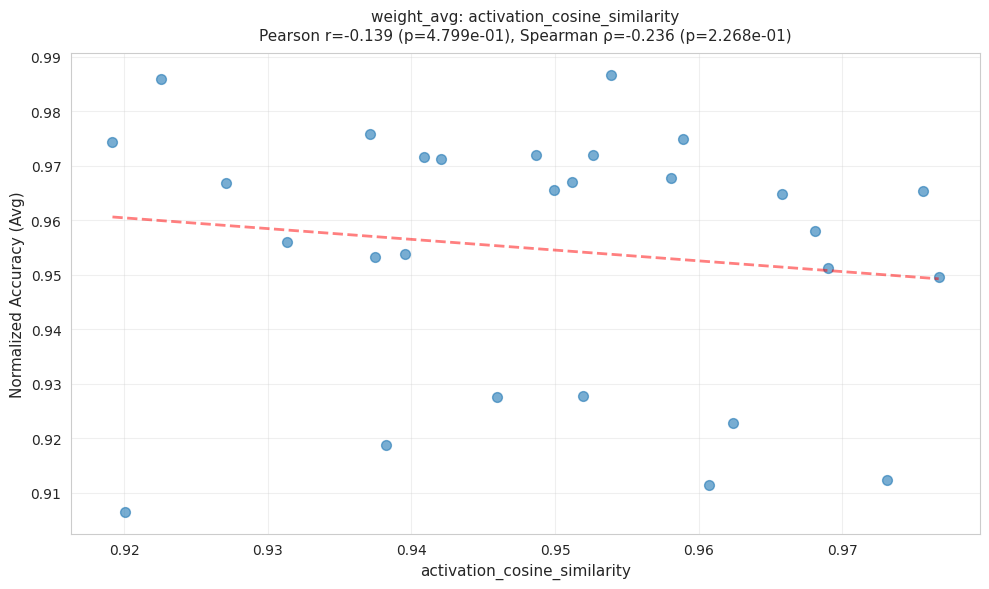


activation_cosine_similarity:
  Data points: 28
  Pearson correlation: r=-0.1392, p=4.7991e-01
  Spearman correlation: ρ=-0.2359, p=2.2684e-01
Saved: weight_avg_activation_l2_distance.png


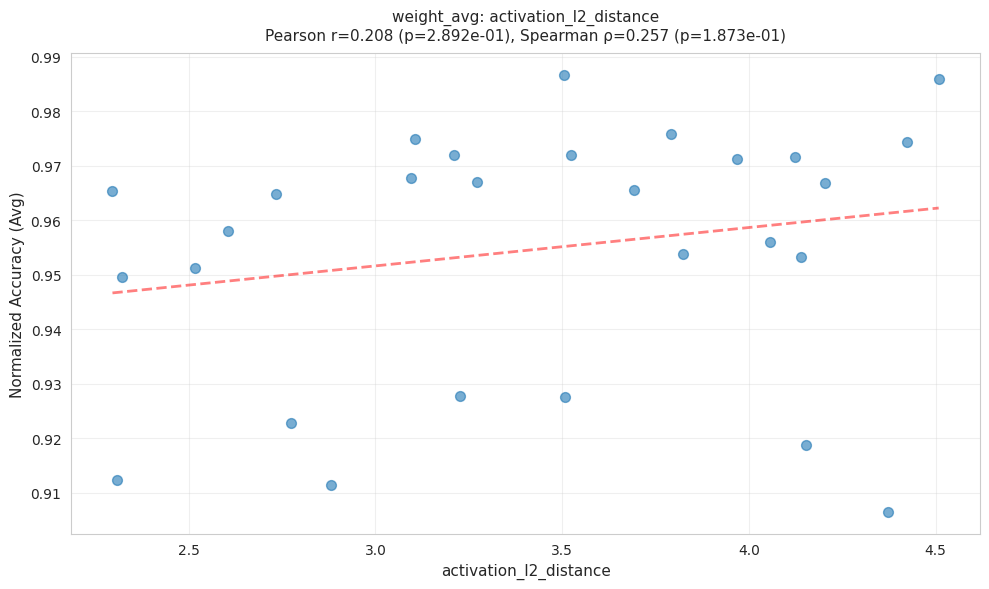


activation_l2_distance:
  Data points: 28
  Pearson correlation: r=0.2076, p=2.8921e-01
  Spearman correlation: ρ=0.2567, p=1.8729e-01
Saved: weight_avg_activation_magnitude_ratio.png


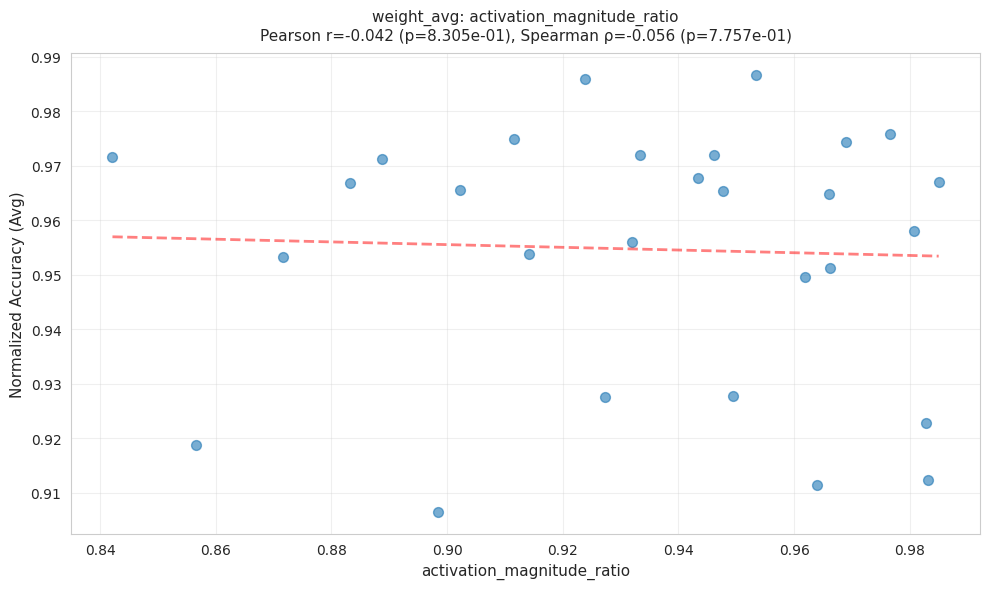


activation_magnitude_ratio:
  Data points: 28
  Pearson correlation: r=-0.0424, p=8.3052e-01
  Spearman correlation: ρ=-0.0564, p=7.7569e-01
Saved: weight_avg_activation_dot_product.png


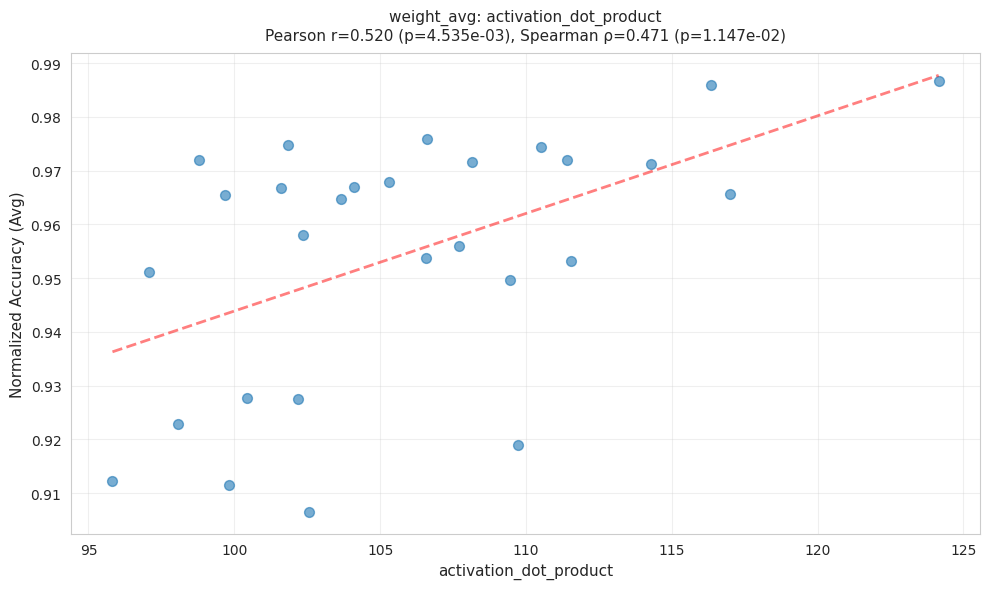


activation_dot_product:
  Data points: 28
  Pearson correlation: r=0.5203, p=4.5346e-03
  Spearman correlation: ρ=0.4707, p=1.1469e-02

Merger: ISOTROPIC
Saved: isotropic_activation_cosine_similarity.png


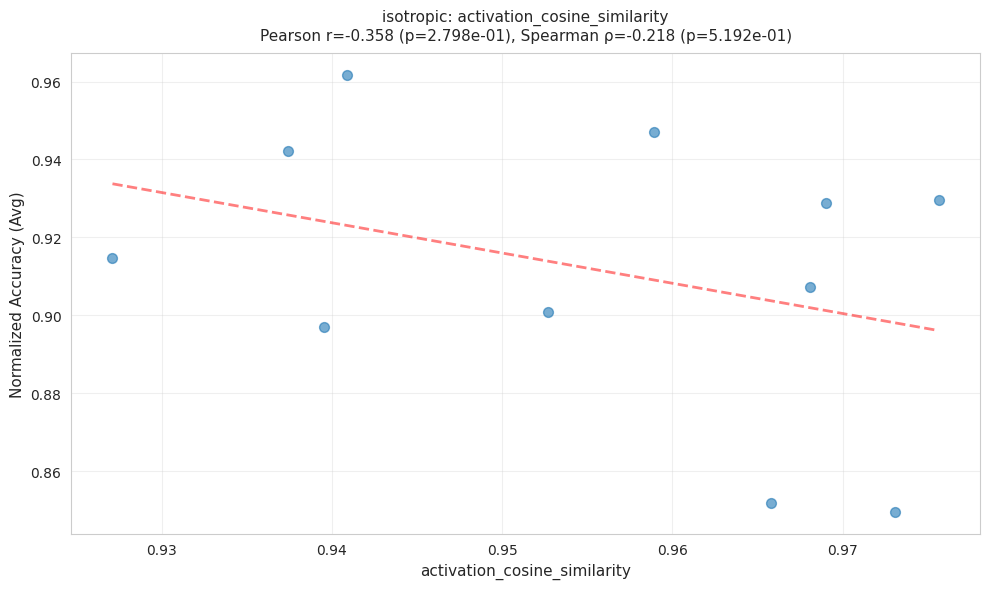


activation_cosine_similarity:
  Data points: 11
  Pearson correlation: r=-0.3579, p=2.7978e-01
  Spearman correlation: ρ=-0.2182, p=5.1925e-01
Saved: isotropic_activation_l2_distance.png


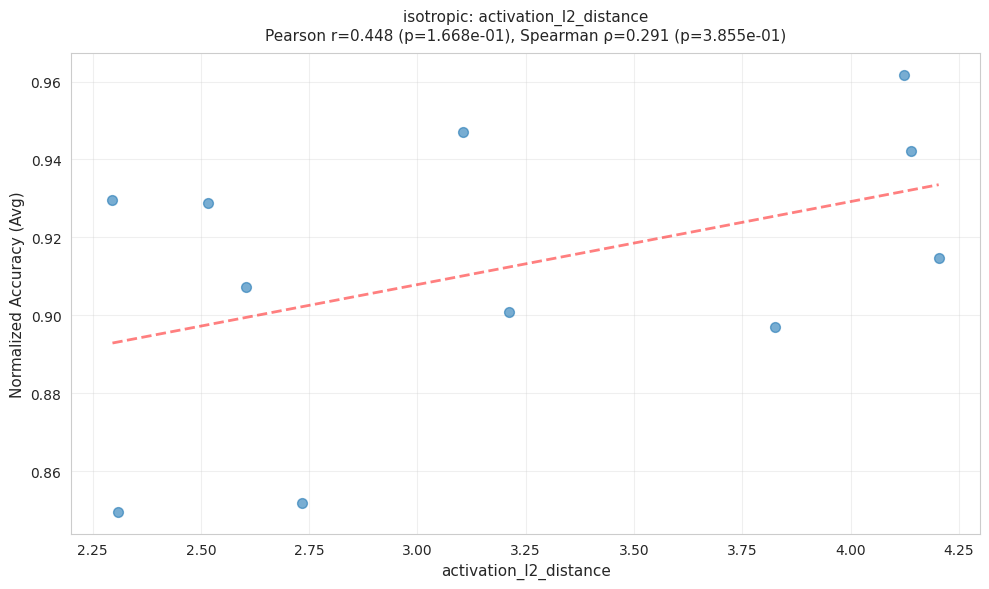


activation_l2_distance:
  Data points: 11
  Pearson correlation: r=0.4482, p=1.6681e-01
  Spearman correlation: ρ=0.2909, p=3.8546e-01
Saved: isotropic_activation_magnitude_ratio.png


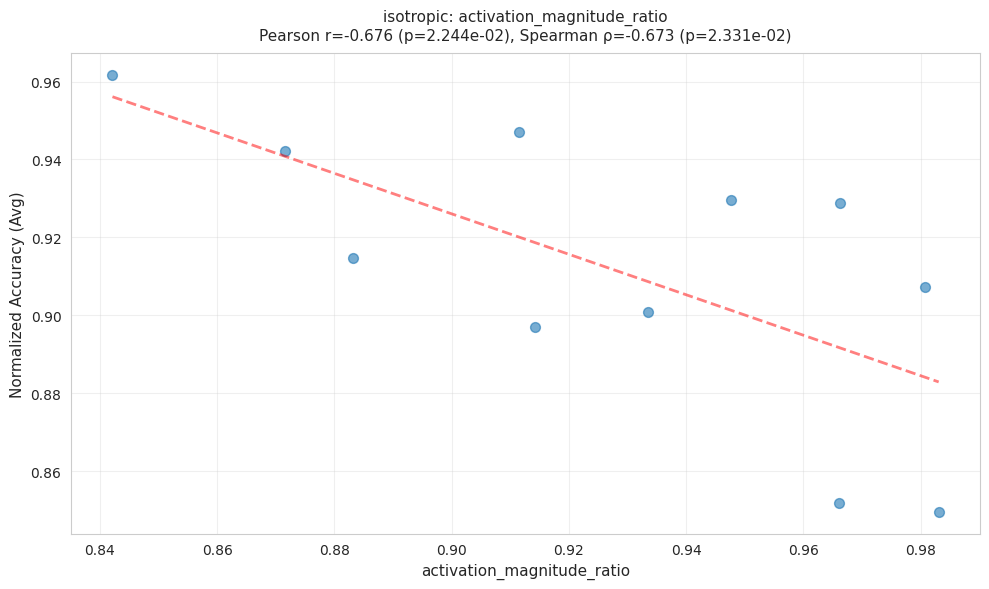


activation_magnitude_ratio:
  Data points: 11
  Pearson correlation: r=-0.6759, p=2.2438e-02
  Spearman correlation: ρ=-0.6727, p=2.3313e-02
Saved: isotropic_activation_dot_product.png


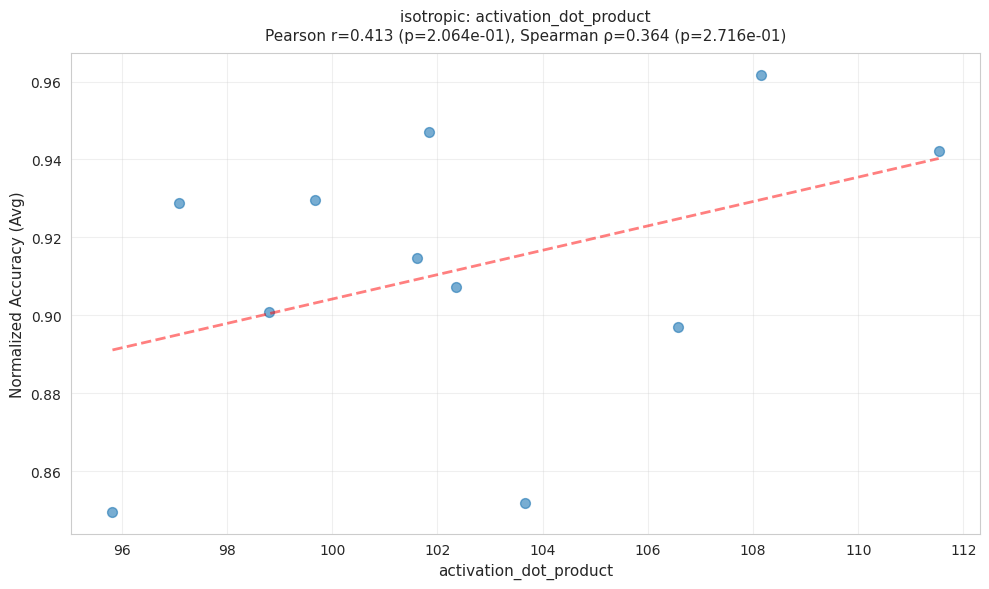


activation_dot_product:
  Data points: 11
  Pearson correlation: r=0.4133, p=2.0639e-01
  Spearman correlation: ρ=0.3636, p=2.7164e-01

Merger: TSV
Saved: tsv_activation_cosine_similarity.png


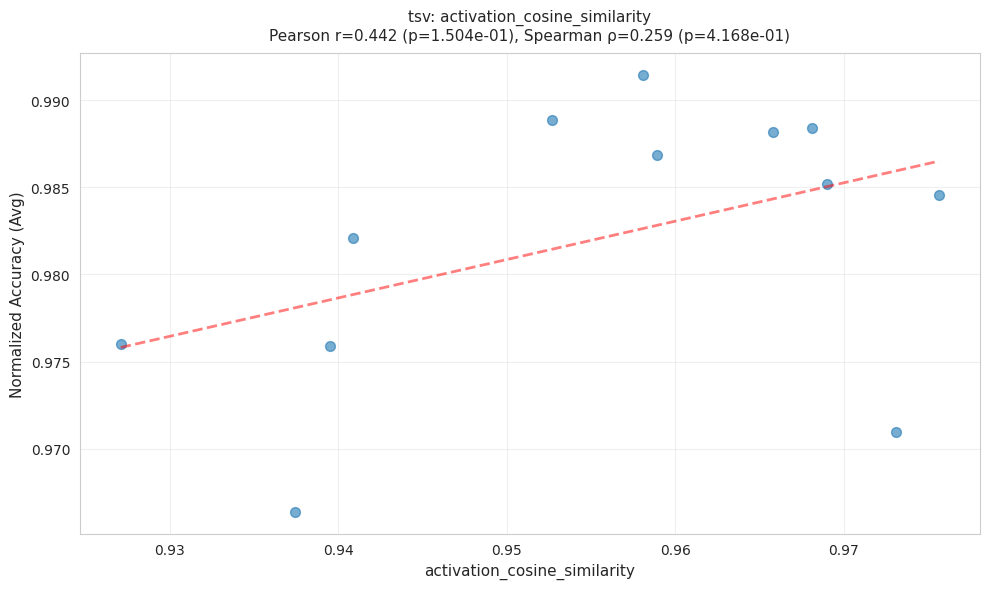


activation_cosine_similarity:
  Data points: 12
  Pearson correlation: r=0.4418, p=1.5041e-01
  Spearman correlation: ρ=0.2587, p=4.1677e-01
Saved: tsv_activation_l2_distance.png


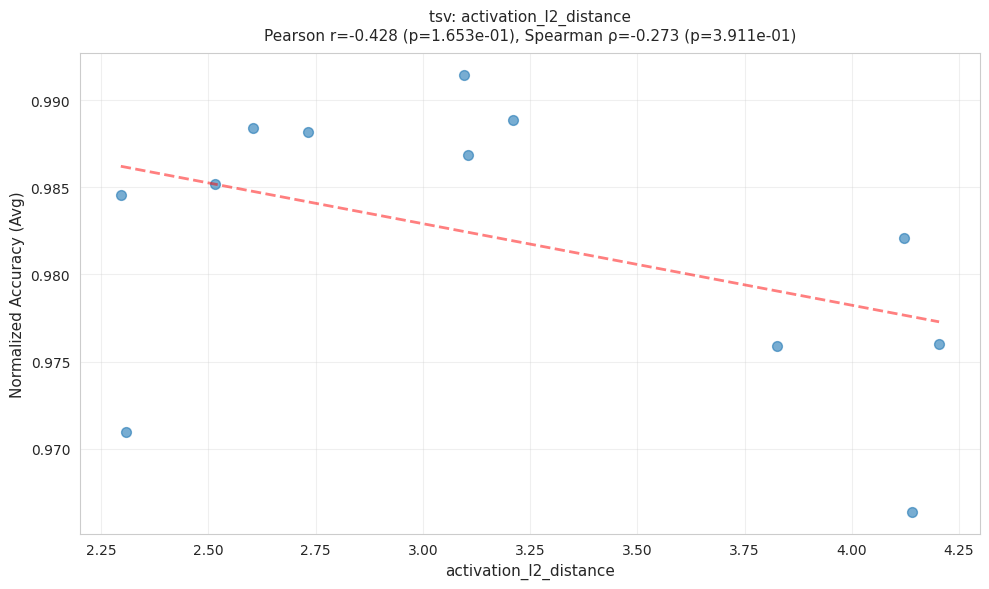


activation_l2_distance:
  Data points: 12
  Pearson correlation: r=-0.4279, p=1.6527e-01
  Spearman correlation: ρ=-0.2727, p=3.9110e-01
Saved: tsv_activation_magnitude_ratio.png


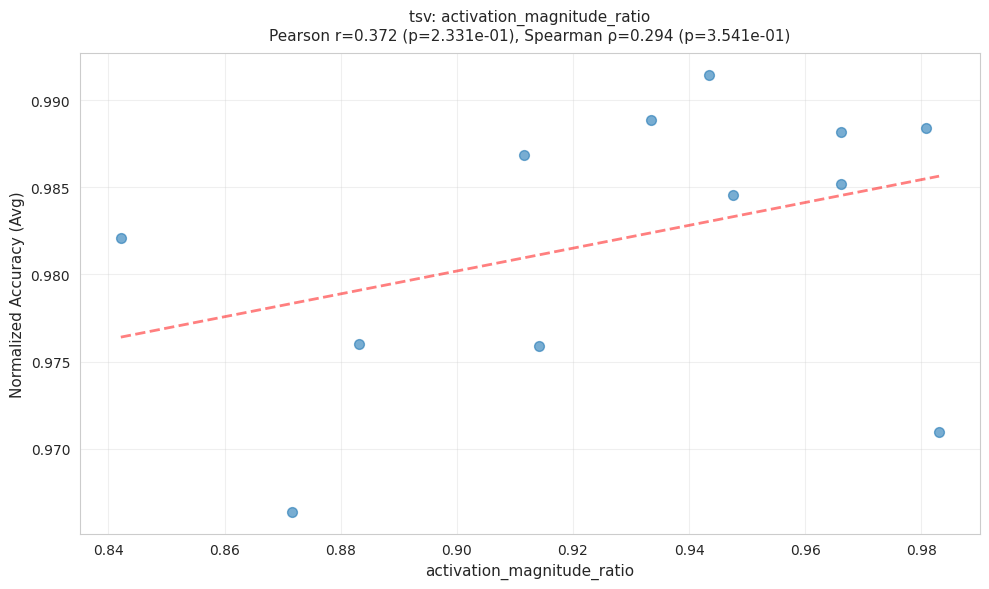


activation_magnitude_ratio:
  Data points: 12
  Pearson correlation: r=0.3725, p=2.3313e-01
  Spearman correlation: ρ=0.2937, p=3.5415e-01
Saved: tsv_activation_dot_product.png


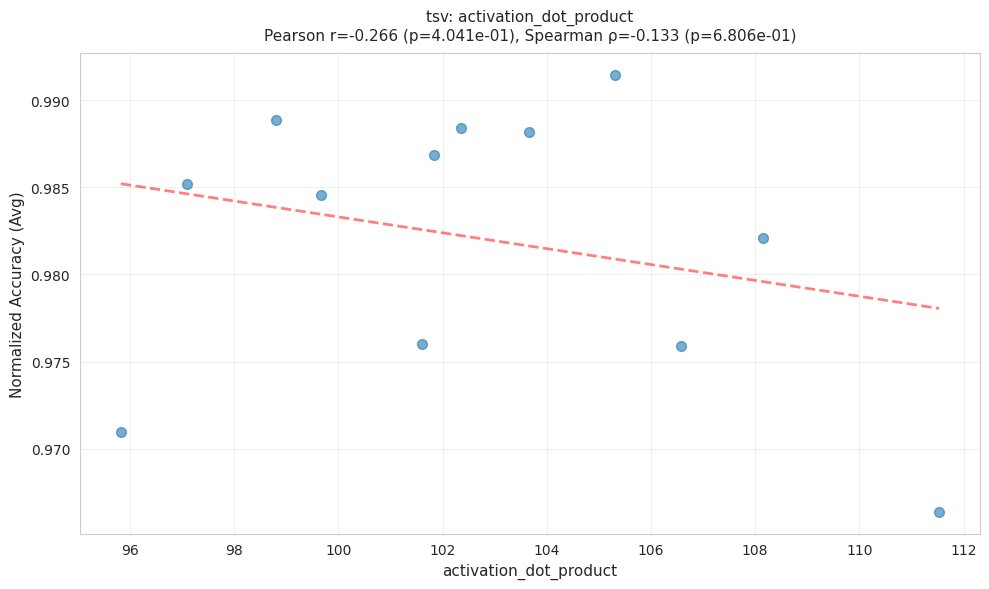


activation_dot_product:
  Data points: 12
  Pearson correlation: r=-0.2656, p=4.0410e-01
  Spearman correlation: ρ=-0.1329, p=6.8060e-01

Merger: ARITHMETIC
Saved: arithmetic_activation_cosine_similarity.png


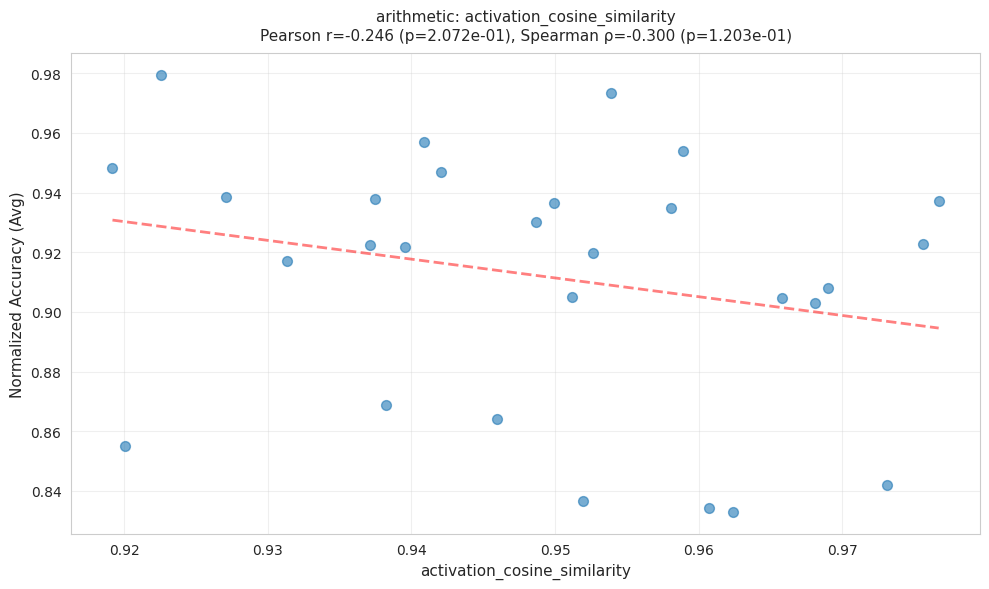


activation_cosine_similarity:
  Data points: 28
  Pearson correlation: r=-0.2459, p=2.0718e-01
  Spearman correlation: ρ=-0.3005, p=1.2025e-01
Saved: arithmetic_activation_l2_distance.png


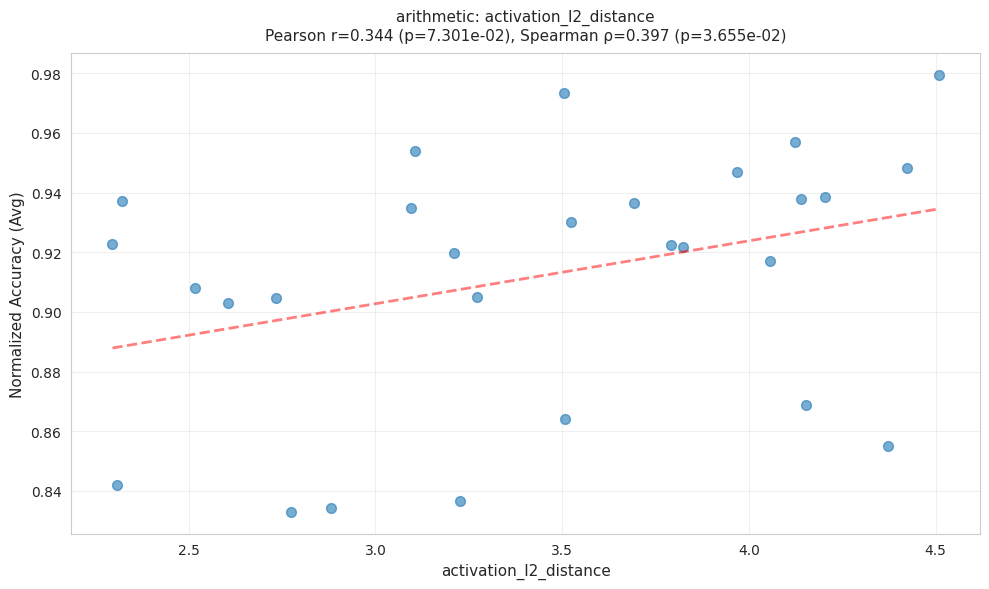


activation_l2_distance:
  Data points: 28
  Pearson correlation: r=0.3441, p=7.3013e-02
  Spearman correlation: ρ=0.3968, p=3.6547e-02
Saved: arithmetic_activation_magnitude_ratio.png


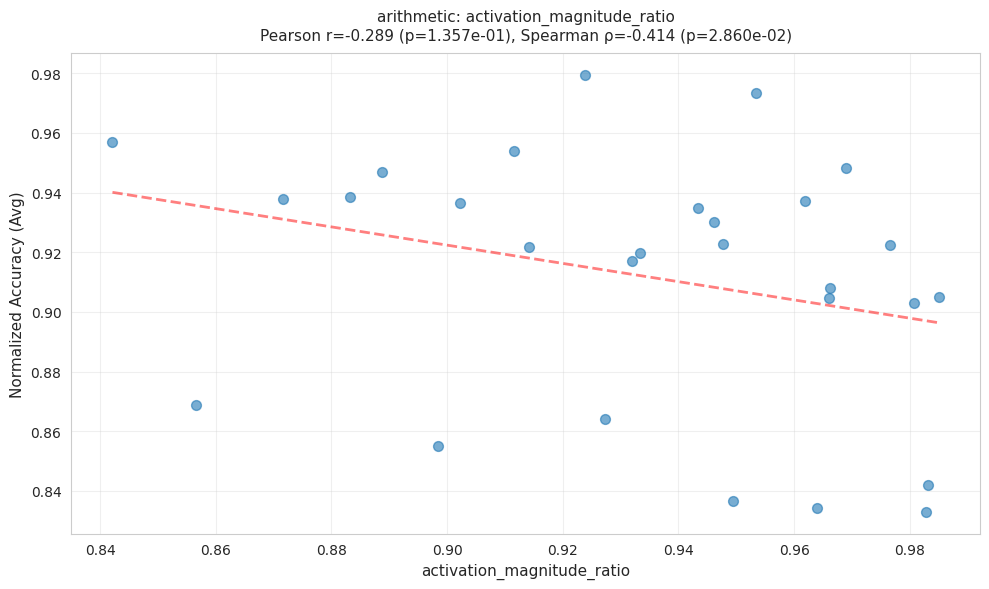


activation_magnitude_ratio:
  Data points: 28
  Pearson correlation: r=-0.2891, p=1.3567e-01
  Spearman correlation: ρ=-0.4138, p=2.8601e-02
Saved: arithmetic_activation_dot_product.png


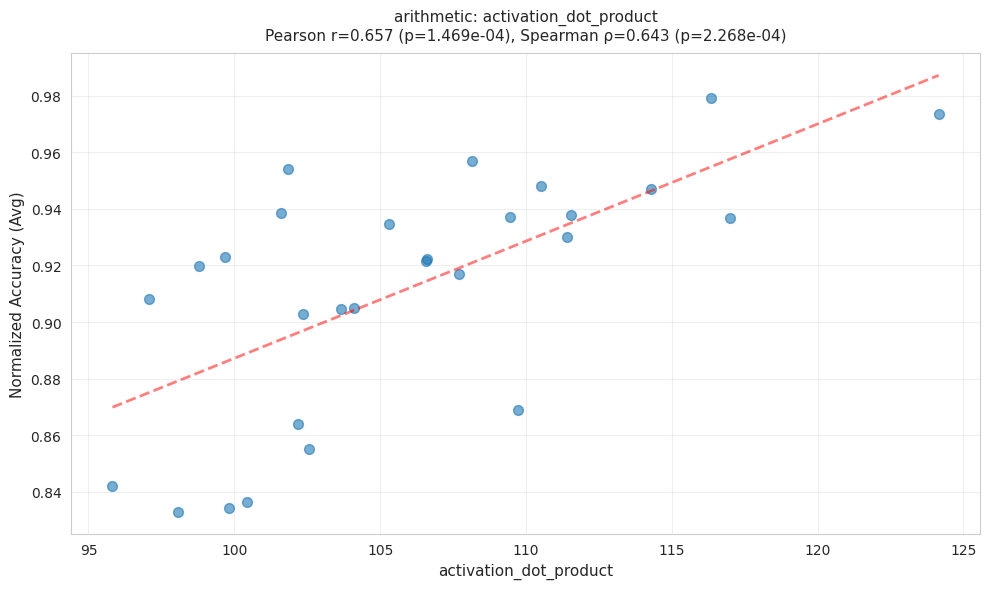


activation_dot_product:
  Data points: 28
  Pearson correlation: r=0.6568, p=1.4687e-04
  Spearman correlation: ρ=0.6426, p=2.2676e-04


In [19]:
# Generate all scatter plots
metric_names = list(mergeability_values.keys())
n_metrics = len(metric_names)
n_mergers = len(merger_methods)

print(f"Generating {n_metrics} x {n_mergers} = {n_metrics * n_mergers} scatter plots...\n")

# Store correlation results
correlation_results = []

for merger in merger_methods:
    print(f"\n{'='*80}")
    print(f"Merger: {merger.upper()}")
    print(f"{'='*80}")
    
    for metric in metric_names:
        x_vals, y_vals, pair_names = create_correlation_data(
            mergeability_values,
            performance_by_merger[merger],
            metric
        )
        
        if len(x_vals) > 0:
            fig, ax = plt.subplots(figsize=(10, 6))
            pearson_r, pearson_p, spearman_r, spearman_p = create_scatter_plot(
                x_vals, y_vals, pair_names, metric, merger, ax
            )
            plt.tight_layout()
            
            # Save the plot
            plot_filename = f"{merger}_{metric}.png"
            plot_path = Path(PLOT_SAVE_PATH) / plot_filename
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {plot_filename}")
            
            plt.show()
            
            # Store results
            correlation_results.append({
                'merger': merger,
                'metric': metric,
                'n_pairs': len(x_vals),
                'pearson_r': pearson_r,
                'pearson_p': pearson_p,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p
            })
            
            print(f"\n{metric}:")
            print(f"  Data points: {len(x_vals)}")
            print(f"  Pearson correlation: r={pearson_r:.4f}, p={pearson_p:.4e}")
            print(f"  Spearman correlation: ρ={spearman_r:.4f}, p={spearman_p:.4e}")
        else:
            print(f"\n{metric}: No data available")

## 6. Summary of Correlations

In [20]:
# Create summary dataframe
correlation_df = pd.DataFrame(correlation_results)
print("\nCorrelation Summary:")
print(correlation_df.to_string(index=False))


Correlation Summary:
    merger                       metric  n_pairs  pearson_r  pearson_p  spearman_r  spearman_p
weight_avg activation_cosine_similarity       28  -0.139200   0.479909   -0.235906    0.226843
weight_avg       activation_l2_distance       28   0.207564   0.289215    0.256705    0.187286
weight_avg   activation_magnitude_ratio       28  -0.042361   0.830524   -0.056377    0.775688
weight_avg       activation_dot_product       28   0.520317   0.004535    0.470717    0.011469
 isotropic activation_cosine_similarity       11  -0.357941   0.279777   -0.218182    0.519248
 isotropic       activation_l2_distance       11   0.448194   0.166807    0.290909    0.385457
 isotropic   activation_magnitude_ratio       11  -0.675864   0.022438   -0.672727    0.023313
 isotropic       activation_dot_product       11   0.413328   0.206387    0.363636    0.271638
       tsv activation_cosine_similarity       12   0.441841   0.150409    0.258741    0.416775
       tsv       activation_

Saved: correlation_heatmaps.png


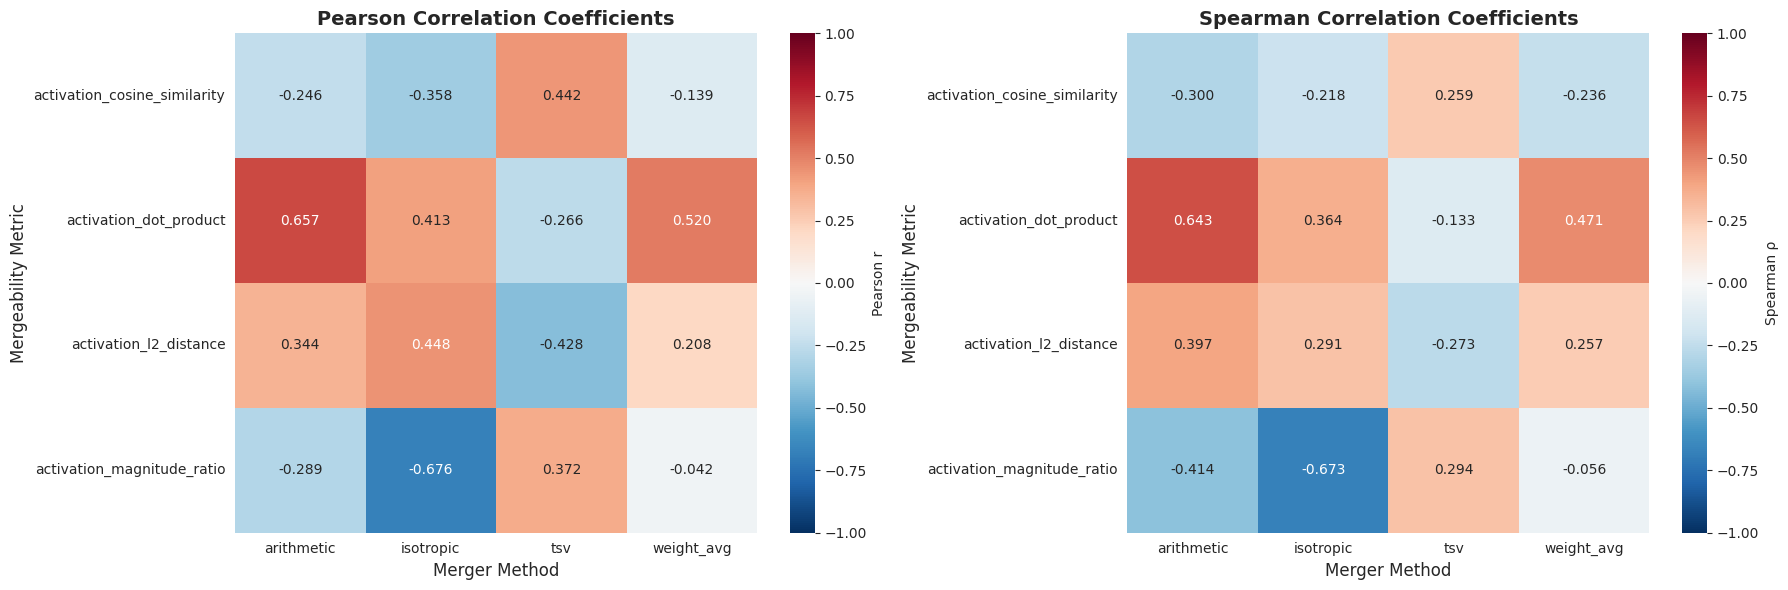

In [21]:
# Visualize correlation strengths as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Pearson correlation heatmap
pearson_pivot = correlation_df.pivot(index='metric', columns='merger', values='pearson_r')
sns.heatmap(pearson_pivot, annot=True, fmt='.3f', cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, ax=axes[0], cbar_kws={'label': 'Pearson r'})
axes[0].set_title('Pearson Correlation Coefficients', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Merger Method', fontsize=12)
axes[0].set_ylabel('Mergeability Metric', fontsize=12)

# Spearman correlation heatmap
spearman_pivot = correlation_df.pivot(index='metric', columns='merger', values='spearman_r')
sns.heatmap(spearman_pivot, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': 'Spearman ρ'})
axes[1].set_title('Spearman Correlation Coefficients', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Merger Method', fontsize=12)
axes[1].set_ylabel('Mergeability Metric', fontsize=12)

plt.tight_layout()

# Save the heatmap
heatmap_path = Path(PLOT_SAVE_PATH) / "correlation_heatmaps.png"
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
print(f"Saved: correlation_heatmaps.png")

plt.show()

## 7. Statistical Significance Analysis

In [22]:
# Filter for statistically significant correlations (p < 0.05)
significant_correlations = correlation_df[
    (correlation_df['pearson_p'] < 0.05) | (correlation_df['spearman_p'] < 0.05)
].copy()

if len(significant_correlations) > 0:
    print("\nStatistically Significant Correlations (p < 0.05):")
    print("="*100)
    for _, row in significant_correlations.iterrows():
        print(f"\n{row['merger']} + {row['metric']}:")
        if row['pearson_p'] < 0.05:
            print(f"  Pearson: r={row['pearson_r']:.4f}, p={row['pearson_p']:.4e} ***")
        else:
            print(f"  Pearson: r={row['pearson_r']:.4f}, p={row['pearson_p']:.4e}")
        
        if row['spearman_p'] < 0.05:
            print(f"  Spearman: ρ={row['spearman_r']:.4f}, p={row['spearman_p']:.4e} ***")
        else:
            print(f"  Spearman: ρ={row['spearman_r']:.4f}, p={row['spearman_p']:.4e}")
else:
    print("\nNo statistically significant correlations found (p < 0.05)")


Statistically Significant Correlations (p < 0.05):

weight_avg + activation_dot_product:
  Pearson: r=0.5203, p=4.5346e-03 ***
  Spearman: ρ=0.4707, p=1.1469e-02 ***

isotropic + activation_magnitude_ratio:
  Pearson: r=-0.6759, p=2.2438e-02 ***
  Spearman: ρ=-0.6727, p=2.3313e-02 ***

arithmetic + activation_l2_distance:
  Pearson: r=0.3441, p=7.3013e-02
  Spearman: ρ=0.3968, p=3.6547e-02 ***

arithmetic + activation_magnitude_ratio:
  Pearson: r=-0.2891, p=1.3567e-01
  Spearman: ρ=-0.4138, p=2.8601e-02 ***

arithmetic + activation_dot_product:
  Pearson: r=0.6568, p=1.4687e-04 ***
  Spearman: ρ=0.6426, p=2.2676e-04 ***


## 8. Best Predictive Metrics

In [23]:
# Rank metrics by absolute correlation strength
correlation_df['abs_pearson_r'] = correlation_df['pearson_r'].abs()
correlation_df['abs_spearman_r'] = correlation_df['spearman_r'].abs()

print("\nTop 10 Strongest Correlations (by Pearson |r|):")
print("="*100)
top_pearson = correlation_df.nlargest(10, 'abs_pearson_r')[[
    'merger', 'metric', 'n_pairs', 'pearson_r', 'pearson_p'
]]
print(top_pearson.to_string(index=False))

print("\n\nTop 10 Strongest Correlations (by Spearman |ρ|):")
print("="*100)
top_spearman = correlation_df.nlargest(10, 'abs_spearman_r')[[
    'merger', 'metric', 'n_pairs', 'spearman_r', 'spearman_p'
]]
print(top_spearman.to_string(index=False))


Top 10 Strongest Correlations (by Pearson |r|):
    merger                       metric  n_pairs  pearson_r  pearson_p
 isotropic   activation_magnitude_ratio       11  -0.675864   0.022438
arithmetic       activation_dot_product       28   0.656797   0.000147
weight_avg       activation_dot_product       28   0.520317   0.004535
 isotropic       activation_l2_distance       11   0.448194   0.166807
       tsv activation_cosine_similarity       12   0.441841   0.150409
       tsv       activation_l2_distance       12  -0.427877   0.165267
 isotropic       activation_dot_product       11   0.413328   0.206387
       tsv   activation_magnitude_ratio       12   0.372466   0.233126
 isotropic activation_cosine_similarity       11  -0.357941   0.279777
arithmetic       activation_l2_distance       28   0.344055   0.073013


Top 10 Strongest Correlations (by Spearman |ρ|):
    merger                       metric  n_pairs  spearman_r  spearman_p
 isotropic   activation_magnitude_ratio       

## 9. Export Results

In [24]:
# Save correlation results to CSV
output_path = Path(PLOT_SAVE_PATH).parent / "correlation_results.csv"
correlation_df.to_csv(output_path, index=False)
print(f"\nCorrelation results saved to: {output_path}")


Correlation results saved to: /home/ubuntu/thesis/MM/model-merging/results/mergeability/ViT-B-16/correlation/correlation_results.csv


## 10. Individual Pair Analysis (Optional)

In [25]:
# Create a detailed table showing all metrics and performance for each pair
def create_detailed_pair_table(mergeability_values, performance_by_merger, datasets):
    """
    Create a comprehensive table with all mergeability metrics and performance values for each pair.
    """
    rows = []
    
    for i in range(len(datasets)):
        for j in range(i + 1, len(datasets)):
            pair_name = f"{datasets[i]}__{datasets[j]}"
            row = {'pair': pair_name, 'task1': datasets[i], 'task2': datasets[j]}
            
            # Add mergeability metrics
            for metric_name, metric_vals in mergeability_values.items():
                row[f"merge_{metric_name}"] = metric_vals.get(pair_name, np.nan)
            
            # Add performance for each merger
            for merger_name, perf_vals in performance_by_merger.items():
                row[f"perf_{merger_name}"] = perf_vals.get(pair_name, np.nan)
            
            rows.append(row)
    
    return pd.DataFrame(rows)

detailed_df = create_detailed_pair_table(mergeability_values, performance_by_merger, datasets)

# Save to CSV
detailed_output_path = Path(PLOT_SAVE_PATH).parent / "detailed_pair_data.csv"
detailed_df.to_csv(detailed_output_path, index=False)
print(f"\nDetailed pair data saved to: {detailed_output_path}")

# Display first few rows
print("\nFirst 5 rows of detailed pair data:")
print(detailed_df.head())


Detailed pair data saved to: /home/ubuntu/thesis/MM/model-merging/results/mergeability/ViT-B-16/correlation/detailed_pair_data.csv

First 5 rows of detailed pair data:
               pair   task1     task2  merge_activation_cosine_similarity  \
0      SUN397__Cars  SUN397      Cars                            0.968995   
1  SUN397__RESISC45  SUN397  RESISC45                            0.975643   
2   SUN397__EuroSAT  SUN397   EuroSAT                            0.958894   
3      SUN397__SVHN  SUN397      SVHN                            0.927112   
4     SUN397__GTSRB  SUN397     GTSRB                            0.952677   

   merge_activation_l2_distance  merge_activation_magnitude_ratio  \
0                      2.516244                          0.966191   
1                      2.296015                          0.947653   
2                      3.105174                          0.911547   
3                      4.203458                          0.883237   
4                      